In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

In [0]:
from sklearn.datasets.samples_generator import make_blobs
# Generate isotropic Gaussian blobs for clustering.

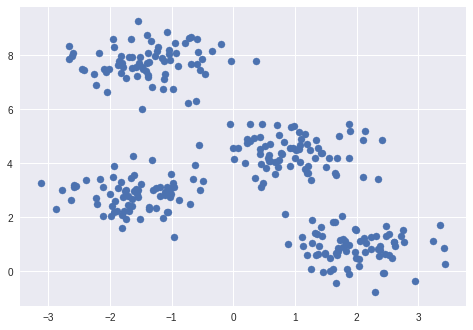

In [3]:
# create dataset
X, labels = make_blobs(n_samples=300, n_features=2, centers=4,
                       cluster_std=0.60, random_state=0)
# http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html
# X = vector with two features
# X Shape = array of shape [n_samples, n_features]
# labels = The integer labels for cluster membership of each sample. 
# labels Shape = array of shape [n_samples]
plt.scatter(X[:, 0], X[:, 1], s=50);

In [0]:
from sklearn.cluster import KMeans

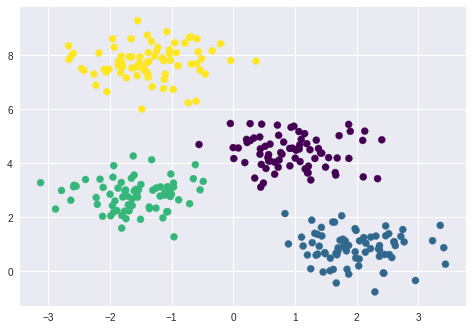

In [5]:
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')
# https://matplotlib.org/api/_as_gen/matplotlib.pyplot.scatter.html
# c = A sequence of n numbers to be mapped to colors.
# s = size of points in graph
# cmap = color map
# real dataset representation with true membership values for each point

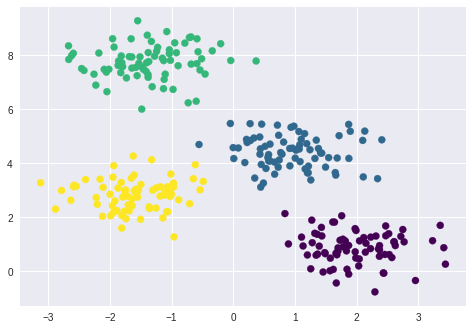

In [6]:
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(X)
labels_pred_kmeans = kmeans.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels_pred_kmeans, s=50, cmap='viridis')
# predicted representation of dataset using Kmeans

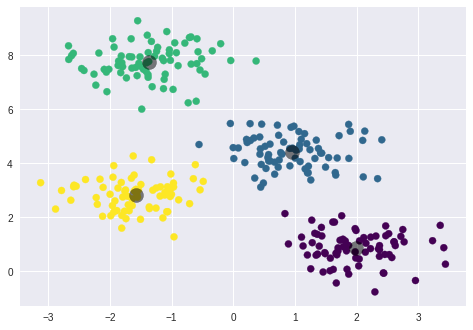

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=labels_pred_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
# centers of each cluster which are predicted using kmeans

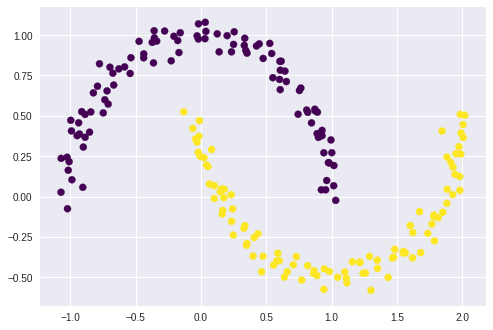

In [8]:
from sklearn.datasets import make_moons
X, labels = make_moons(200, noise=.05, random_state=0)
# Actual dataset representation
plt.scatter(X[:,0],X[:,1],c=labels,s=50, cmap='viridis')

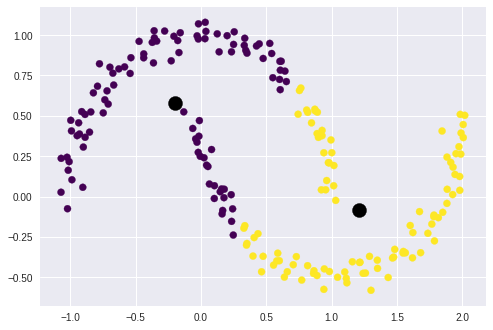

In [9]:
# K-Means fails to correctly differentiate the two clusters

kmeans = KMeans(2, random_state=0)
labels_pred_kmeans = kmeans.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels_pred_kmeans,
            s=50, cmap='viridis');
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black',
            s=200, cmap='viridis');

In [10]:
from sklearn.metrics import accuracy_score
accuracy_score(labels,labels_pred_kmeans)

0.755

In [0]:
import cStringIO # *much* faster than StringIO
import urllib
from PIL import Image
import numpy as np

def url_to_image(url):
  file = urllib.urlopen(url)
  img_data = cStringIO.StringIO(file.read()) # constructs a StringIO holding the image
  img = Image.open(img_data)
  return img

def image_to_rgbarray(image):
  return np.array(image)


(321, 481, 3)

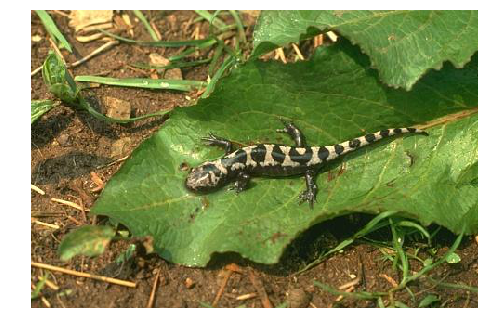

In [12]:
# Note: this requires the ``pillow`` package to be installed
#from sklearn.datasets import load_sample_image

import numpy as np

#image = load_sample_image("flower.jpg")

url = 'https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/files/175083_img.jpg'
original_image = url_to_image(url)
image = image_to_rgbarray(original_image)


plt.figure()
plt.axis("off")
plt.imshow(image)
image.shape

In [13]:
original_shape = image.shape
image = image.reshape((image.shape[0] * image.shape[1], image.shape[2]))

image.shape

(154401, 3)

In [0]:
import random

def black_and_white_mode():
  colors = [(0,0,0),(255,255,255)]
  return colors

def color_mode(bit,shape):
  color_min = 0
  color_max = 255
  colors = []
  for i in range(0,shape[0]):
    colors.append((random.randint(color_min,color_max),random.randint(color_min,color_max),random.randint(color_min,color_max)))
  return colors
  
  

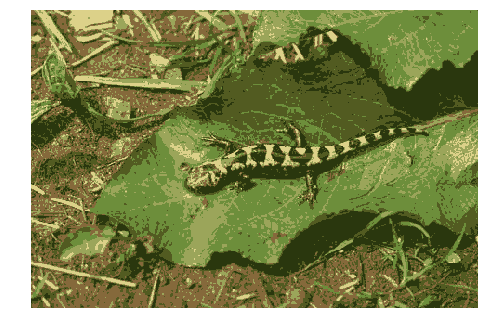

In [15]:
# cluster_count = 2 for B&W mode
# cluster_count > 2 for color mode

cluster_count = 6

kmeans = KMeans(n_clusters=cluster_count)
kmeans.fit(image)
labels = kmeans.predict(image)

centers = kmeans.cluster_centers_

# colors = color_mode(cluster_count,centers.shape)
# colors = black_and_white_mode()
colors = centers



for i in range(0,image.shape[0]):
    cluster_no = labels[i]
    image[i,:] = colors[cluster_no]
    
image = image.reshape(original_shape)

image.shape

plt.figure()
plt.axis("off")
# plt.gray()
plt.imshow(image)

In [16]:
!pip install scikit-fuzzy

    100% |████████████████████████████████| 993kB 16.8MB/s 
  Running setup.py bdist_wheel for scikit-fuzzy ... - \ done
  Stored in directory: /root/.cache/pip/wheels/d3/9a/97/5a2dda0bb9d165b68c35a9ee9f5779b0665b96dddb98773205
Successfully built scikit-fuzzy


In [0]:
def change_color_fuzzycmeans(cluster_membership, cluster_centers):
    image = []
    for pixel in cluster_membership.T:
        image.append(cluster_centers[np.argmax(pixel)])
    return image

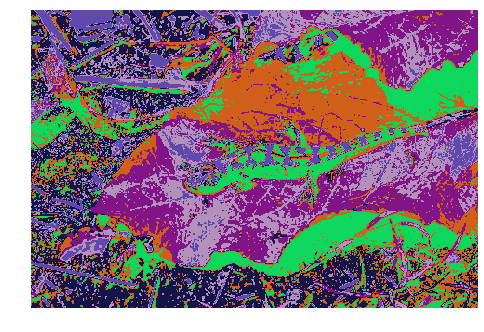

In [18]:
import skfuzzy as fuzzy

# https://pythonhosted.org/scikit-fuzzy/api/skfuzzy.html#skfuzzy.cmeans

url = 'https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/files/175083_img.jpg'
original_image = url_to_image(url)
image = image_to_rgbarray(original_image)

original_shape = image.shape
image = image.reshape((image.shape[0] * image.shape[1], image.shape[2]))

cluster_count = 6


cntr,u,u0,d,jm,p,fpc = fuzzy.cmeans(data=image.T,c=cluster_count,m=3, error=0.0001, maxiter=1000, init=None, seed=None)

colors = cntr # centers
labels = u # membership values of a pixel for each cluster

fuzzy_image = change_color_fuzzycmeans(labels,colors)
fuzzy_img = np.reshape(fuzzy_image,original_shape)

plt.figure()
plt.axis("off")
plt.imshow(fuzzy_img)